# Kernel density estimators

The concepts that this notebook will illustrate are:
* Writing kernel density functions
* Using list comprehensions to generate data
* Using lambda functions to pass functions to other functions
* Basic plotting

## The problem

Sometimes in research, your goal might be to approximate the distribution of the data you have. This can be because you are doing some kind of prediction exercise where you want to be able to reproduce the data from some set of covariates, or simply because you want to summarise the distribution in a graph in a sensible way. But given a set of data points, which are inherently discrete, how to smooth these into an approximation of a density?

For example, consider you get a dataset with 50 points. Because we are creating this dataset here we know what distribution these data come from, but you wouldn't know that as a researcher just receiving the data points. Let's make some weird data and take a look.

**First** you will need to install the following packages via conda if you dont have them already. In terminal:
```
conda activate are212
conda install -c conda-forge matplotlib
```

In [1]:
import numpy as np
from scipy.stats import distributions as iid
from numpy import random
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# 1. create the true density with a (strange) density
def our_pdf(N):
    # distribution support 
    a = 0
    b = 2*np.pi
    x = np.linspace(a, b, N)
    
    return {'pdf' : (np.sin(x*6*2*np.pi/(a-b)) + 1)/(b - a), 'x' : x}

# method for noisy sampling
def sample(N, pdf=our_pdf):
    # create large data -> approximates true distribution
    large_data_x, large_data_p = our_pdf(10000)['x'], our_pdf(10000)['pdf']
    # sample from this using discretized probabilities
    sample = random.choice(large_data_x, p=large_data_p/large_data_p.sum(), size=(N))
    return sample    

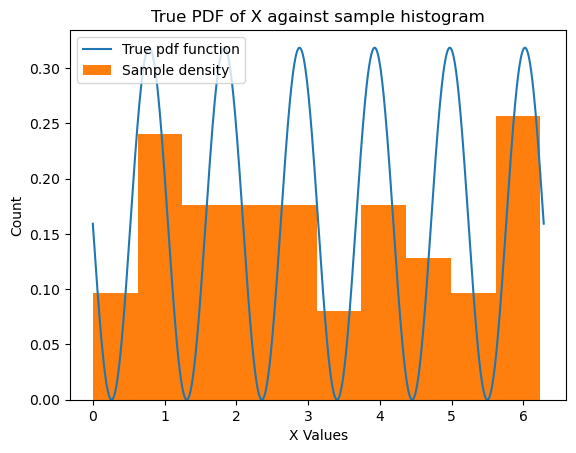

In [3]:
# 2. Visualize the distribution 

# the true distribution is produced with large enough N
true_distrib = our_pdf(10000)
X = sample(100)

fig, ax = plt.subplots()
ax.plot(true_distrib['x'], true_distrib['pdf'], label='True pdf function')
ax.hist(X, density=True, bins=int(np.sqrt(100)), label='Sample density')

ax.set(xlabel='X Values', ylabel='Count',title="True PDF of X against sample histogram")
plt.legend(loc=2)

## A solution

Above we can get some sense of the distribution with a histogram, but this is not totally satisfying since the histogram is literally chunky- it is a set of rectangles, whereas these sharp edges don't actually exist in our data. So what is another way to approximate the distribution? Kernel densities. 

### Some math

Now that we know that the goal of a kernel density is to approximate a PDF, let's do some math. We know that a PDF ($f$) is the derivative of a CDF ($F$). We don't actually know the CDF, but we can use the empirical distirbution to define:

$$\widehat{F}(x) = \frac{1}{n}\sum_i 1(X_i \leq x)$$

**Check your understanding:** Why doesn't this kind of approximation work to create $\hat{f}(x) = P(X_i = x)$?

With this, using the definition of a derivative, let:
\begin{align*}
\hat{f}(x) &= \frac{\widehat{F}(x+h) - \widehat{F}(x-h)}{2h} \\
&= \frac{1}{2h} \sum_i \frac{1(X_i \leq x+h)}{n} - \frac{1(X_i \leq x-h)}{n} \\
&= \frac{1}{2h} \sum_i \frac{1(x-h\leq X_i \leq x+h)}{n} \\
&= \frac{1}{2hn} \sum_i 1(-1\leq \frac{X_i - x}{h} \leq 1) \\
&= \frac{1}{2hn} \sum_i 1(\frac{|X_i - x|}{h} \leq 1) \\
\end{align*}

Calling the $1()$ function $k(u) = 1/2$ if $u\leq 1$, where $u = \frac{1}{h}(X_i-x)$, we have a kernel density. But we don't have to limit $k()$ to be an indicator function. We can use any function that is:
1. Non-negative
2. Bounded
3. Symmetric
4. Differentiable

For example, these are all kernel densities (the last one is Cauchy, from the kernel density exercises):

\begin{align}
K_1(u) &= \begin{cases}
1/2 & |u| < 1 \\ 
0 & \text{otherwise}
\end{cases} \\ 
K_2(u) &= \begin{cases}
\frac{1-u}{2} & |u| < 1 \\
0 & \text{otherwise}
\end{cases} \\ 
K_3(u) &= \begin{cases}
\frac{3}{4\sqrt{5}}(1-\frac{u^2}{5}) & |u| < \sqrt{5} \\
0 & \text{otherwise}
\end{cases}
\end{align}

Let's program a simulation that takes each of these kernel densities and plots it against the true (oracle) density.

One trick that will help us with these indicator functions is that the boolean ``True`` in python evaluates to 1. So we can multiply our expressions by a boolean that checks if the conditional is satisfied to push everything else outside to 0.

In [4]:
print(sum([True, False, True]))
print(f"(1 < 2)*1 = {(1 < 2)*1}")
print(f"(1 > 2)*1 = {(1 > 2)*1}")

2
(1 < 2)*1 = 1
(1 > 2)*1 = 0


In [5]:
# define kernel densities. First, see that these 3 options for K_1 are all equivalent
def K1(u):
    return 0.5*(np.abs(u) < 1)

def K1_1(u):
    if np.abs(u) < 1:
        return 0.5
    else:
        return 0

K1_2 = lambda u: 0.5*(np.abs(u) < 1)

In [6]:
print(f" K1(0)   = {K1(0)}\n K1_1(0) = {K1_1(0)}\n K1_2(0) = {K1_2(0)}")

 K1(0)   = 0.5
 K1_1(0) = 0.5
 K1_2(0) = 0.5


In [7]:
def K2(u):
    return 0.5*(1-u)*(np.abs(u) < 1)

def K3(u):
    return 3/(4*5**0.5)*(1-u**2/5)*(np.abs(u) < 5**0.5)

Now let's make a dictionary of kernel functions that we will later loop over to estimate the kernel density function at each point in x. These functions will be a function of $u$.

In [8]:
kernels = {"Uniform" : K1,
           "Linear"  : K2,
           "Cauchy"  : K3
          }

# test: kernels['Linear'] returns a function that we can then call
kernels['Linear'](0.8)

0.09999999999999998

Now for each kernel, we want to estimate it at each point in the data. Let's also loop over a few bandwidths just for fun. We'll do 2 bandwidths, which plus the 3 kernels implies 6 total plots. The idea is:

```
for each bandwidth and each kernel:
    calculate f_hat(x) = (1/nh) \sum_i k((x_i - x)/h) for each x in the data
```

For readability, let's write f_hat as a function first. ``f_hat()`` needs to know:
* The kernel function k()
* h
* x
* The data X

**Aside:** The ``apply()`` method of ``pd.Series()``

The ``pandas`` (usually imported as ``pd``) package is the main data organizer in python, and has a ton of really great functions. The main data types in pandas are:
* ``pd.Series``
* ``pd.DataFrame``, where eachs column is a ``pd.Series``. 

You can subset pandas dataframe columns by calling ``df['colname']`` or ``df.colname``, which will then return a pandas Series. Series can have lots of different operations done to them, and when you have a custom operation you can use the ``apply`` method of ``pd.Series`` to apply the function to each entry in the column. Calling apply works like this:

In [9]:
X_test = pd.Series([1,2,3,4], name='test')
print(X_test)

0    1
1    2
2    3
3    4
Name: test, dtype: int64


In [10]:
def evenOrOdd(x, oppositeDay=False):
    if (x % 2 == 0 and not oppositeDay) or (x % 2 == 1 and oppositeDay):
        return "Even"
    if (x % 2 == 0 and oppositeDay) or (x % 2 == 1 and not oppositeDay):
        return "Odd"

# when just a function of one variable, can call function name directly
X_test.apply(evenOrOdd)

0     Odd
1    Even
2     Odd
3    Even
Name: test, dtype: object

In [11]:
# when a function of > 1 var, use lambda functions to mask the other ones
X_test.apply(lambda x: evenOrOdd(x, True))

0    Even
1     Odd
2    Even
3     Odd
Name: test, dtype: object

In [13]:
def f_hat(x, X, h, k):
    '''
    x: double, A point to evaluate f_hat at
    X: pd.Series, an array of data points
    h: double, bandwidth
    k: function, the kernel density function
    
    Returns: double, 1/(nh) \sum_i k((x_i - x)/h)
    '''
    n = len(X)
    
    # apply kernel function to each element of X
    k_h = X.apply(lambda x_i: k((x_i - x)/h))
    
    return (1/(n*h))*np.sum(k_h)

# test
f_hat(0, pd.Series(X), 5, kernels["Linear"])

0.041014101010572734

Text(0.5, 0.98, 'Estimated PDF with different kernels, bandwidths')

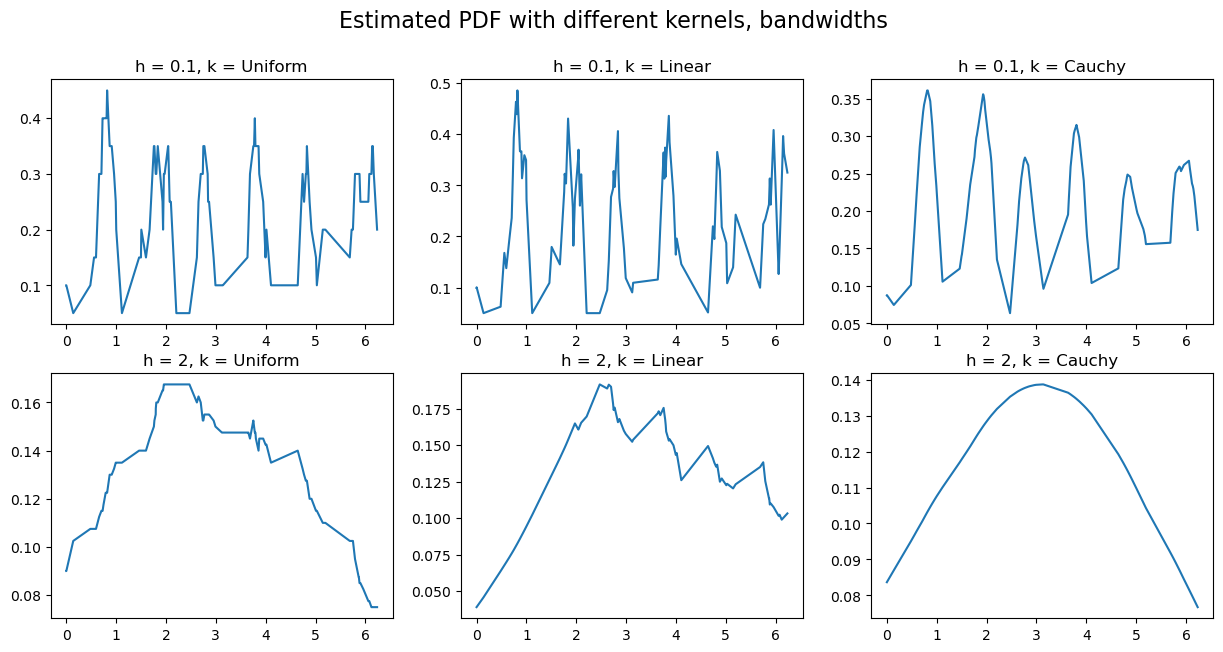

In [14]:
# initialize figure space
fig, ax = plt.subplots(2, 3, figsize=(15,7))
# sort X so we move across the axis
X = pd.Series(X).sort_values()

# counter is for axis positioning
counter = 0

for h in [.1, 2]: # loop over bandwidths
    for name, k in kernels.items(): # loop over kernel names, functions
        # row moves to 1 after 3rd iteration
        if counter < 3:
            row = 0
        else:
            row = 1
        # calculate fhat for each x, plot against x
        ax[row, counter % 3].plot(X, X.apply(lambda x_i: f_hat(x_i, X, h, k)))
        # label 
        ax[row, counter % 3].set_title(f'h = {h}, k = {name}')
        # move counter forward
        counter += 1
      
fig.suptitle("Estimated PDF with different kernels, bandwidths", size=16)